### Download the dataset from kaggle

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/blood-cells


### Necessary Libraries

In [12]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Here we do classification part so we work on dataset2-master  folder

In [13]:
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images'

# List the contents of the images directory
print(os.listdir(data_dir))


['TEST_SIMPLE', 'TEST', 'TRAIN']


*****checking the folders in train*****

In [14]:
import os

data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

# List the contents of the images directory
print(os.listdir(data_dir))


['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']


**show the first few 5 datapaths and its labels**

In [15]:


# Set the path to the images folder
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

# Define the class labels (folder names)
class_labels = ['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class folder and collect image file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure only image files are included
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# Create a DataFrame
bloodcell_df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# Shuffle the dataset
bloodcell_df = bloodcell_df.sample(frac=1).reset_index(drop=True)

# Show the first few rows
bloodcell_df.head()


,filepath,label
0,/kaggle/input/blood-cells/dataset2-master/data...,LYMPHOCYTE
1,/kaggle/input/blood-cells/dataset2-master/data...,MONOCYTE
2,/kaggle/input/blood-cells/dataset2-master/data...,MONOCYTE
3,/kaggle/input/blood-cells/dataset2-master/data...,LYMPHOCYTE
4,/kaggle/input/blood-cells/dataset2-master/data...,EOSINOPHIL


**Random picture for visualization**

In [16]:
import matplotlib.pyplot as plt
import cv2

def show_images(df, num_images=25):
    plt.figure(figsize=(15, 15))
    
    # Pick random samples
    sample_df = df.sample(n=num_images).reset_index(drop=True)
    
    for i in range(num_images):
        filepath = sample_df.loc[i, 'filepath']
        label = sample_df.loc[i, 'label']
        
        # Read the image using OpenCV and convert BGR to RGB
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


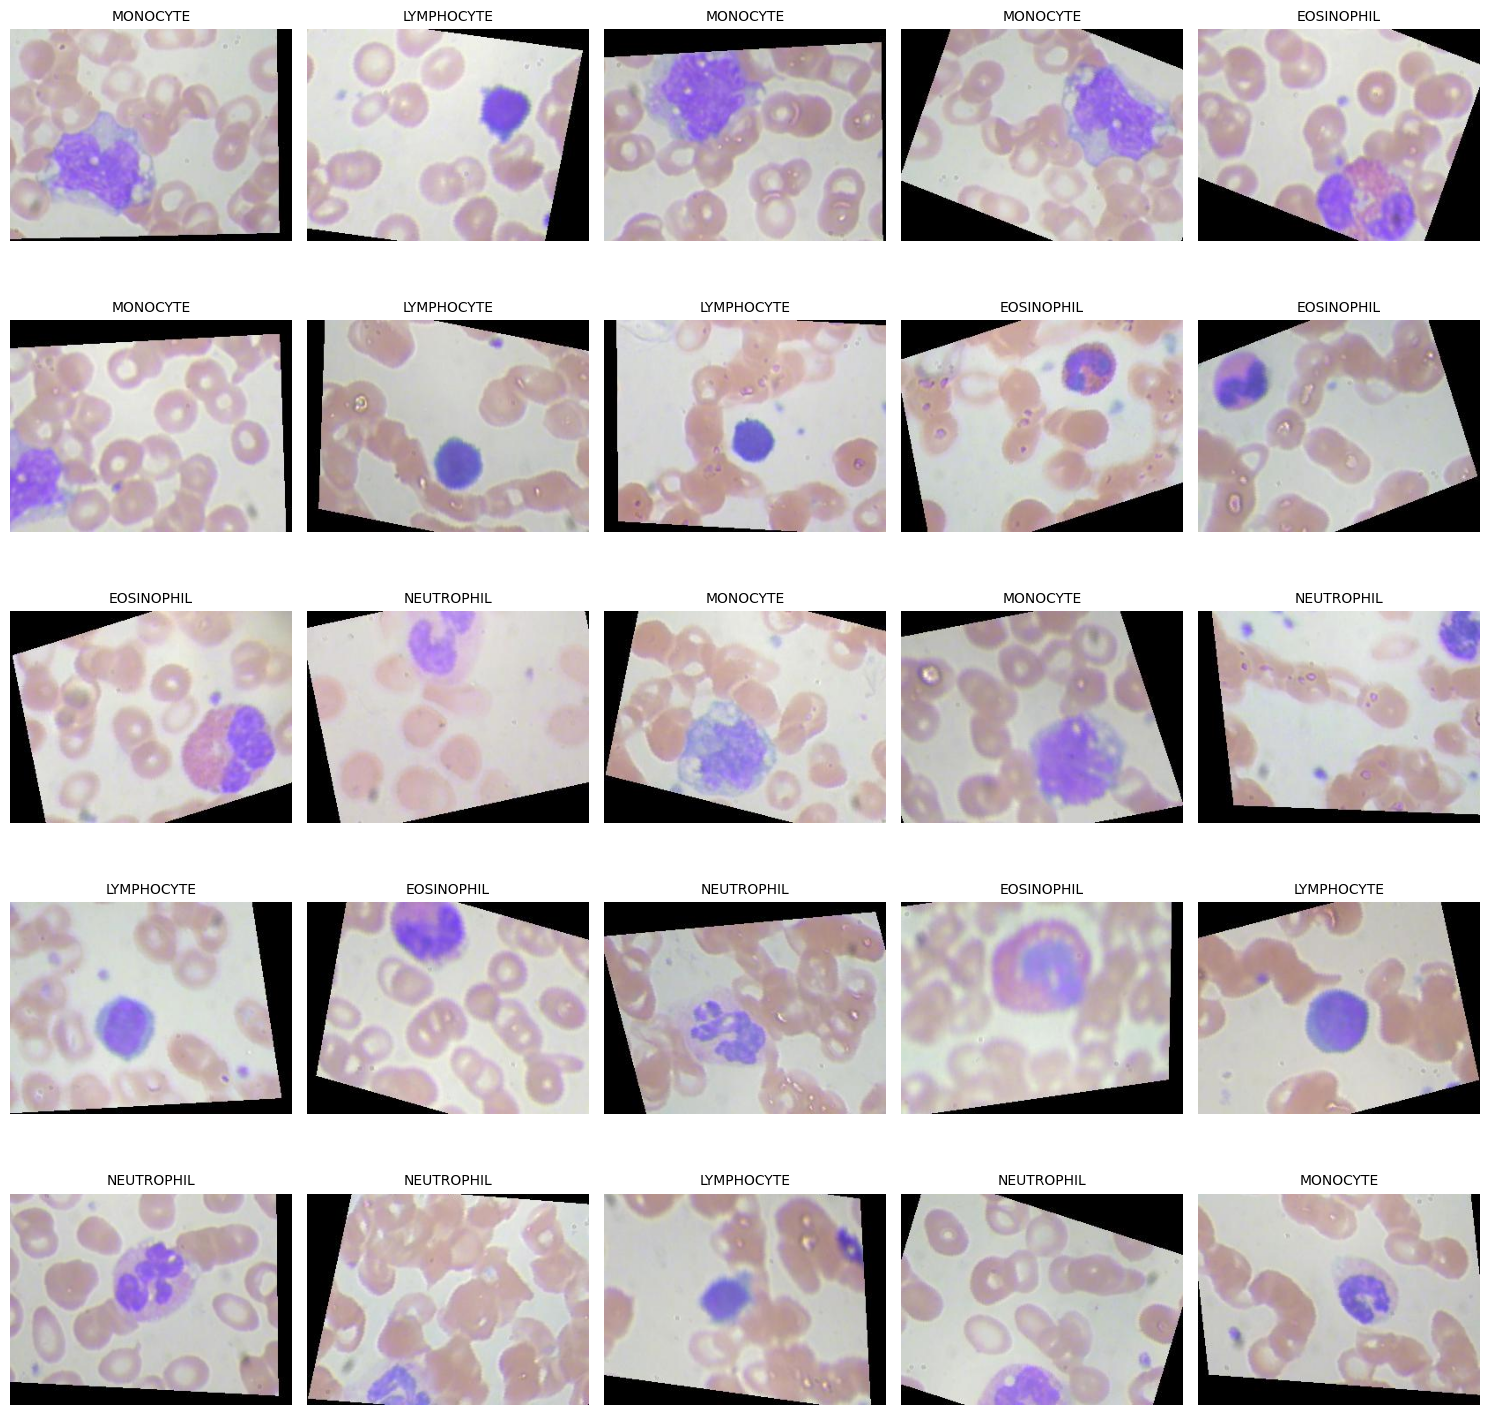

In [17]:
show_images(bloodcell_df)


In [18]:
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images'

train_dir = os.path.join(data_dir, 'TRAIN')
val_dir   = os.path.join(data_dir, 'TEST_SIMPLE')   # or use TRAIN with validation_split
test_dir  = os.path.join(data_dir, 'TEST')


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [27]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("Blood Cell.h5", monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751104234.990702    1668 service.cc:148] XLA service 0x7952340041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751104234.990770    1668 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751104234.990777    1668 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751104239.546096    1668 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751104260.581526    1668 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


312/312 ━━━━━━━━━━━━━━━━━━━━ 234s 515ms/step - accuracy: 0.7274 - loss: 0.6176 - val_accuracy: 0.0845 - val_loss: 1.7047
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 126s 402ms/step - accuracy: 0.9739 - loss: 0.0702 - val_accuracy: 0.6761 - val_loss: 0.9634
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 125s 399ms/step - accuracy: 0.9816 - loss: 0.0557 - val_accuracy: 0.6761 - val_loss: 2.5427
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 126s 404ms/step - accuracy: 0.9842 - loss: 0.0510 - val_accuracy: 0.8451 - val_loss: 0.8522
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 125s 400ms/step - accuracy: 0.9909 - loss: 0.0338 - val_accuracy: 0.9155 - val_loss: 0.8777
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 396ms/step - accuracy: 0.9921 - loss: 0.0227 - val_accuracy: 0.8873 - val_loss: 0.5532
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 398ms/step - accuracy: 0.9915 - loss: 0.0271 - val_accuracy: 0.9014 - val_loss: 0.5480
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 398ms/step - accuracy: 0.9883 - loss: 0.03

In [ ]:
model.load_weights("Blood Cell.h5")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))